# How to Train a CellTypist Model on Xenium Data

#### **Prerequisites**: 
- A virtual enviroment (eg conda environment) with CellTypist from the Teich Lab installed (refer to [the GitHub](https://github.com/Teichlab/celltypist))
- Preprocessed & segmented Xenium dataset saved as in AnnData format
    - Either nuclear or cell segmentation 
- Cell type marker genes to label cells or existing cell type labels for the Xenium dataset 

For this workflow, I will be using the **10X Xenium Colon** dataset (avaliable [here](https://www.10xgenomics.com/datasets/human-colon-preview-data-xenium-human-colon-gene-expression-panel-1-standard)) that is used in the Segger paper (Heidari, Moorman et al. [*bioRxiv*](https://www.biorxiv.org/content/10.1101/2025.03.14.643160v1) 2025, [GitHub](https://github.com/dpeerlab/segger-analysis/)). The cell markers were currated by Andrew Moorman and used for the Segger workflow. 

In [1]:
import celltypist as ct
import ast
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import warnings
import json
import sys
import os

## Add cell type labels to a segmented 10X dataset
CellTypist relies on a scRNAseq dataset with predetermined cell type labels to train a model. If you do not already have cell type assignments for your dataset, here is how to create those labels using a currated set of marker genes. If you do not have a list of genes already assembled, refer to literature that outlines common marker genes for cell types you want to identify in your data. However, it is important to remember to limit your search to genes that exist within your panel, otherwise (without an imputation method) it wont be useful for labelling your data.

In [2]:
data_name = '10x_colon_nucleus'
## Read in AnnData - here using nuclear segmentation of the 10x Colon data.
filepath_nuc = f'data_spatial/{data_name}_processed_clean.h5ad' # replace with your own path
ad_nuc = sc.read_h5ad(filepath_nuc)

## Read in cell type markers 
filepath_mark = 'data_spatial/cell_type_markers.csv' # replace with your own path
markers = pd.read_csv(filepath_mark, index_col=0)

In this dataframe, group denotes the cell type groups we want to be using in our analysis. 

In [3]:
markers

,gene,label,compartment,source,group,level_1,level_2
0,ABCC8,enteroendocrine cell of colon,epithelial,10X Genomics,NaN,NaN,NaN
1,ADH1C,progenitor cell,epithelial,10X Genomics,NaN,NaN,NaN
2,ADRA2A,paneth cell of colon,epithelial,10X Genomics,Paneth Cell,Paneth,Epithelial
3,AFAP1L2,tuft cell,epithelial,10X Genomics,Tuft Cell,Tuft,Epithelial
4,AGTR1,enteroendocrine cell of colon,epithelial,10X Genomics,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15,GREM2,Smooth Muscle Cell,stromal,Custom,Smooth Muscle Cell,Smooth Muscle,Smooth Muscle and Pericyte
16,IL1B,Neutrophil,immune,Custom,Neutrophil,Neutrophil,Myeloid
17,CXCR1,Neutrophil,immune,Custom,Neutrophil,Neutrophil,Myeloid
18,CXCR2,Neutrophil,immune,Custom,Neutrophil,Neutrophil,Myeloid


We z-score the data in order make genes more comparable by removing any scaling differences (often a technical artifact). If you already completed this step in your preprocessing, skip it here. 

In [4]:
# Z-score data before gene set scoring
X = ad_nuc.layers['lognorm'].todense().A
ad_nuc.layers['z-score'] = sp.stats.zscore(X, axis=0)

`sc.tl.score_genes` is a scanpy function that assigns a cell-type score to each cell based on the averaged expression of marker genes. So every cell gets a set of scores that quantify the probability of it belonging to every cell type. 

In [5]:
# Ignore performance warnings from calling insert
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Score all genes
ad_nuc.X = ad_nuc.layers['z-score']
col = 'group'
for name, group in tqdm(markers.groupby(col)):
    sc.tl.score_genes(
        adata=ad_nuc,
        gene_list=group['gene'].unique(),
        score_name=name,
        use_raw=False,
    )
    
# Join into single .obsm entry
ad_nuc.obsm['X_cell_type'] = ad_nuc.obs[markers[col].dropna().unique()]

100%|██████████| 33/33 [00:19<00:00,  1.66it/s]


While you could cell type each cell on its own by picking out the highest scoring cell type for each cell independatly, this will not result in the cleanest cell typing. Since groups of similar cells often "group together" in gene expression space, we can use clustering methods to aggregate alike cells to create a more homogenous and cohesive cell typing.  

In [6]:
# Max cell type by cluster
gb = 'phenograph_cluster'
fn = 'mean'
ct_agg = sc.get.aggregate(ad_nuc, gb, fn, obsm='X_cell_type').to_df(layer=fn)
ct_agg.index = ct_agg.index.astype(int)
ct_map = ct_agg.idxmax(1)

# Map cluster/compartment assignments to dataset
ad_nuc.obs['prelim_cell_type'] = ad_nuc.obs[gb].map(ct_map)

If you have a high level classification for your marker genes that you want to use for easy visualization or other analysis, you can add that as another cell type label. 

In [7]:
# Compartment by cluster
cp_map = markers.dropna().set_index(col)['compartment']
cp_map = cp_map[~cp_map.index.duplicated()]

ad_nuc.obs['prelim_cell_type_coarse'] = ad_nuc.obs['prelim_cell_type'].map(cp_map)

And now you can visualize your data with cell types and you can also use this as an opportunity to adjust or assess any assignments. It is important that you are confident in the cell typing at this step as it will be used for building a CellTypist Model. 

... storing 'prelim_cell_type' as categorical
... storing 'prelim_cell_type_coarse' as categorical


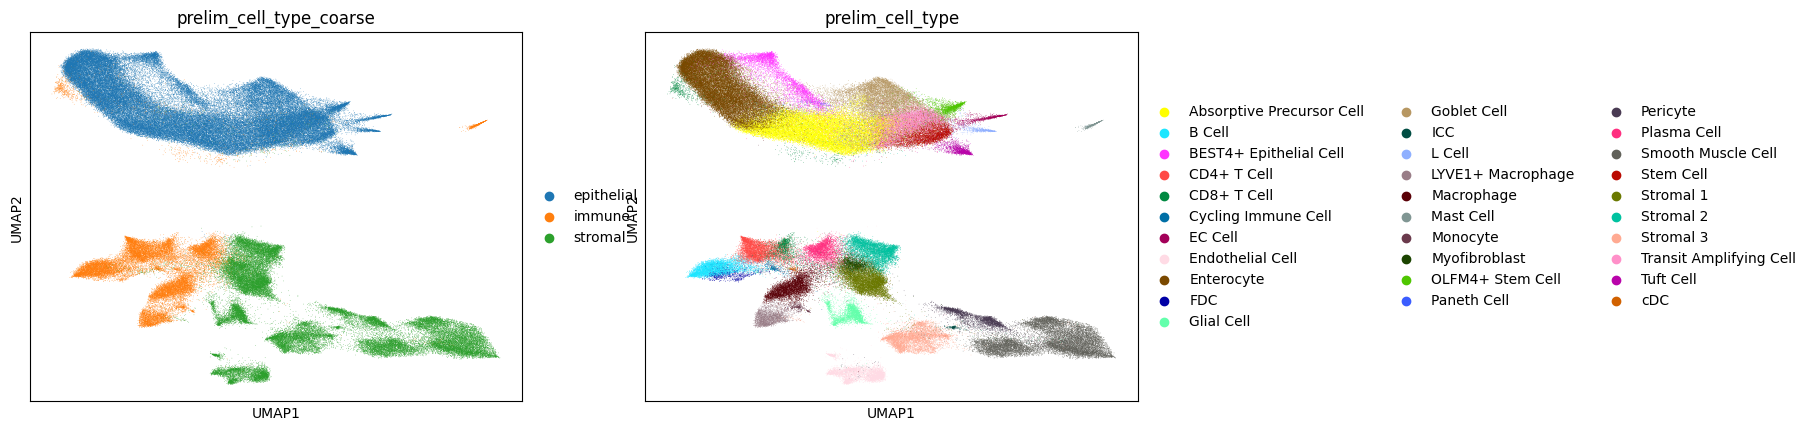

In [8]:
sc.pl.umap(ad_nuc, color = ['prelim_cell_type_coarse','prelim_cell_type'])

## Training a CellTypist Model on 10X data
For a more in-depth explanation of CellTypist and model training, refer to this [SAIL GitHub](https://github.com/joadams1/celltypist/blob/main/celltypist/How%20To%20Train%20a%20CellTypist%20Model.ipynb).

Once you have cell type labels for your Xenium dataset, you can move on to training a CellTypist Model using this function. It requires: 
- `ad_atlas`: Cell typed 10X Xenium dataset saved as an AnnData object
- `celltype_col`: the column in `ad_atlas.obs` that contains the cell labels at the granularity you want to use
- `raw_layer`: the `.layers` in `ad_atlas` that contains the raw counts for each cell 
- `target_sum`: the number of counts per cell to normalize the data to (default: 1000)
- `sample_size`: the number of cells from each cell type to train on to avoid overrepresentation of certain cell types (default: 5000)
- `use_GPU`: whether to train the model using GPU, which will be faster (so better for larger datasets) but requires the package cuml (default: False)

It will return the trained CellTypist model that you then will be able to apply to other datasets

In [9]:
def build_celltypist_model(
    ad_atlas: sc.AnnData,
    celltype_col: str, 
    raw_layer: str,
    target_sum: int = 1000,
    sample_size: int = 5000,
    use_GPU: bool=  False
):
    # Re-normalize counts
    t = target_sum
    ad_atlas.X = ad_atlas.layers[raw_layer].copy()
    sc.pp.downsample_counts(ad_atlas, counts_per_cell=t)
    ad_atlas.layers[f'norm_{t}'] = ad_atlas.X.copy()
    sc.pp.normalize_total(ad_atlas, layer=f'norm_{t}', target_sum=t)
    
    # Logarthmize
    ad_atlas.layers[f'lognorm_{t}'] = ad_atlas.layers[f'norm_{t}'].copy()
    if 'log1p' in ad_atlas.uns:
        del ad_atlas.uns['log1p']
    sc.pp.log1p(ad_atlas, layer=f'lognorm_{t}')
    
    # Subsample using more granular cell types (to not lose any one cell type)
    # But transfer labels using the compartment labels
    gb = ad_atlas.obs.groupby(celltype_col, observed=True)
    sample = gb.sample(sample_size, replace=True).index.drop_duplicates()
    
    # Predict on log counts
    ad_atlas.X = ad_atlas.layers[f'lognorm_{t}']

    ct_model = ct.train(
        ad_atlas[sample],
        labels=celltype_col,
        use_GPU=use_GPU,
        check_expression=False,)
    
    return ct_model

In [10]:
# Build Celltypist model on nuclear AnnData
ad_nuc.layers['raw'] = ad_nuc.raw.X.copy()
ct_model = build_celltypist_model(
    ad_nuc,
    celltype_col='prelim_cell_type',
    raw_layer='raw',
    target_sum=100,
    sample_size=1000,
    use_GPU = False
)
outpath_model = f'models/{data_name}_celltypist_model.pkl' #replace with your own path
ct_model.write(outpath_model)

🍳 Preparing data before training
🔬 Input data has 23569 cells and 425 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Now you can use this model to train other datasets. For an explanatory work-through for how to do so, see the [`Using Xenium CellTypist Models`](https://github.com/joadams1/spatial_celltypist/blob/main/Using%20Xenium%20CellTypist%20Model.ipynb) notebook. 